In [357]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, ExpSineSquared, RBF, RationalQuadratic

from matplotlib.ticker import FormatStrFormatter
from scipy import stats
sns.set_style(
    style='darkgrid',
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [358]:
df = pd.read_csv('../data/newDS.csv')
df = df[df['symbolId'].str.contains("BTC_USD")]
df = df[(np.abs(stats.zscore(df.select_dtypes(include=np.number))) < 3).all(axis=1)]

t = np.arange(len(df))
df['t'] = pd.DataFrame({'t' : t})

print('OK - data loaded successfully')

n = 200

df = df[:n]

OK - data loaded successfully


In [359]:
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 1.5**2))

k1 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=0.01, periodicity=1, periodicity_bounds=(1e-3, 45))

k2 = ConstantKernel(constant_value=0.1, constant_value_bounds=(1e-2, 500)) * \
  RationalQuadratic(length_scale=0.01, length_scale_bounds=(0.01, 1e8), alpha= 15.0, alpha_bounds=(1, 1e3))

k3 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=0.01, periodicity=10, periodicity_bounds=(1, 15))

kernel_4  = k0 + k1 + k2 + k3

In [361]:
# Define GaussianProcessRegressor object.
gp4 = GaussianProcessRegressor(
    kernel=kernel_4,
    n_restarts_optimizer=10,
    normalize_y=True,
    alpha=0.0
)

df['delta'] = 10000 * (df['askPrice'].shift(-1) / df['askPrice'] - 1)
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)

X = df['t'].values.reshape(n, 1)
y = df['delta'].values.reshape(n, 1)

prop_train = 0.8
n_train = round(prop_train * n)

X_train = X[:n_train]
X_test = X[n_train:]
y_train = y[:n_train]
y_test = y[n_train:]

160


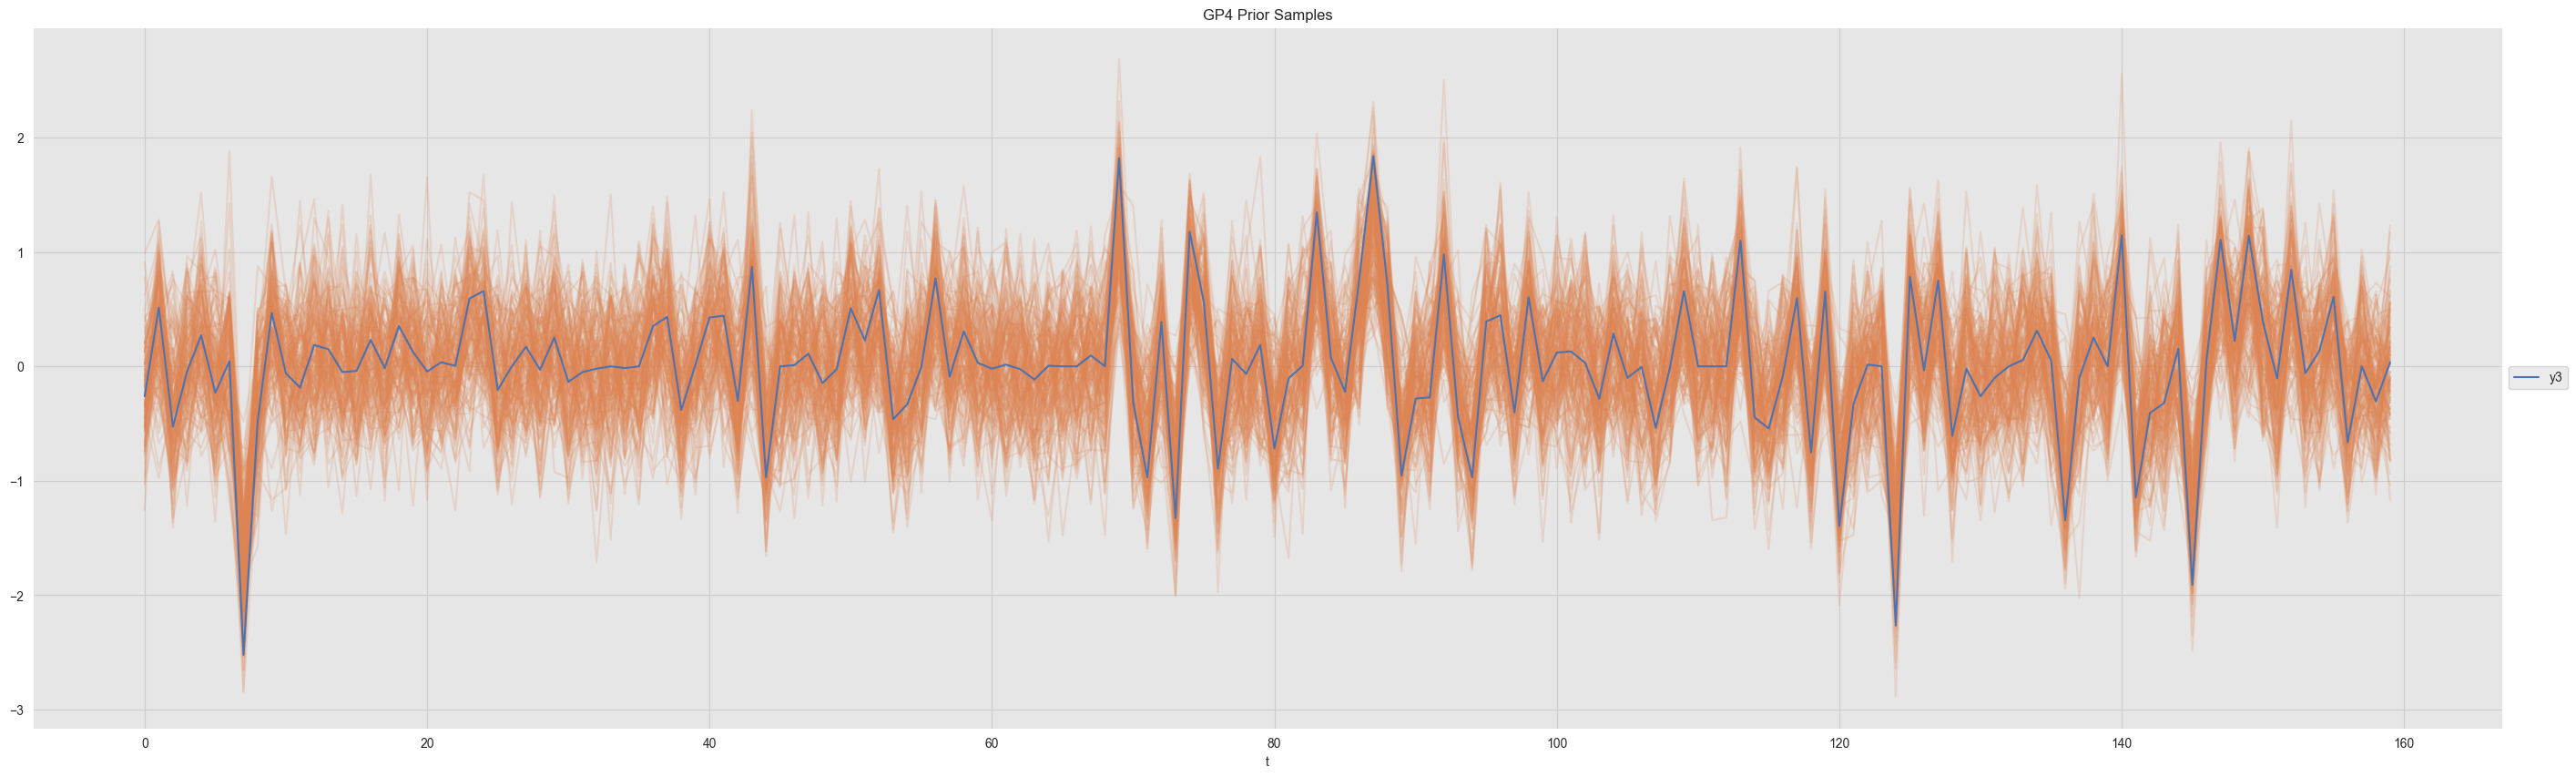

In [375]:
gp4_prior_samples = gp4.sample_y(X=X_train, n_samples=150)

print(len(X_train))

fig, ax = plt.subplots(figsize=(35,10))
for i in range(150):
    sns.lineplot(x=X_train[...,0], y = gp4_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y3', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP4 Prior Samples', xlabel='t');

In [376]:
gp4.fit(X_train, y_train)
GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.5**2) + 1.41**2 * ExpSineSquared(length_scale=0.001, periodicity=1) + 1**2 * RationalQuadratic(alpha=5, length_scale=0.001) + 1**2 * ExpSineSquared(length_scale=0.001, periodicity=1),
                         n_restarts_optimizer=10, normalize_y=True)
y_pred, y_std = gp4.predict(X, return_std=True)

df['y_pred'] = y_pred
df['y_std'] = y_std
df['y_pred_lwr'] = df['y_pred'] - 2*df['y_std']
df['y_pred_upr'] = df['y_pred'] + 2*df['y_std']

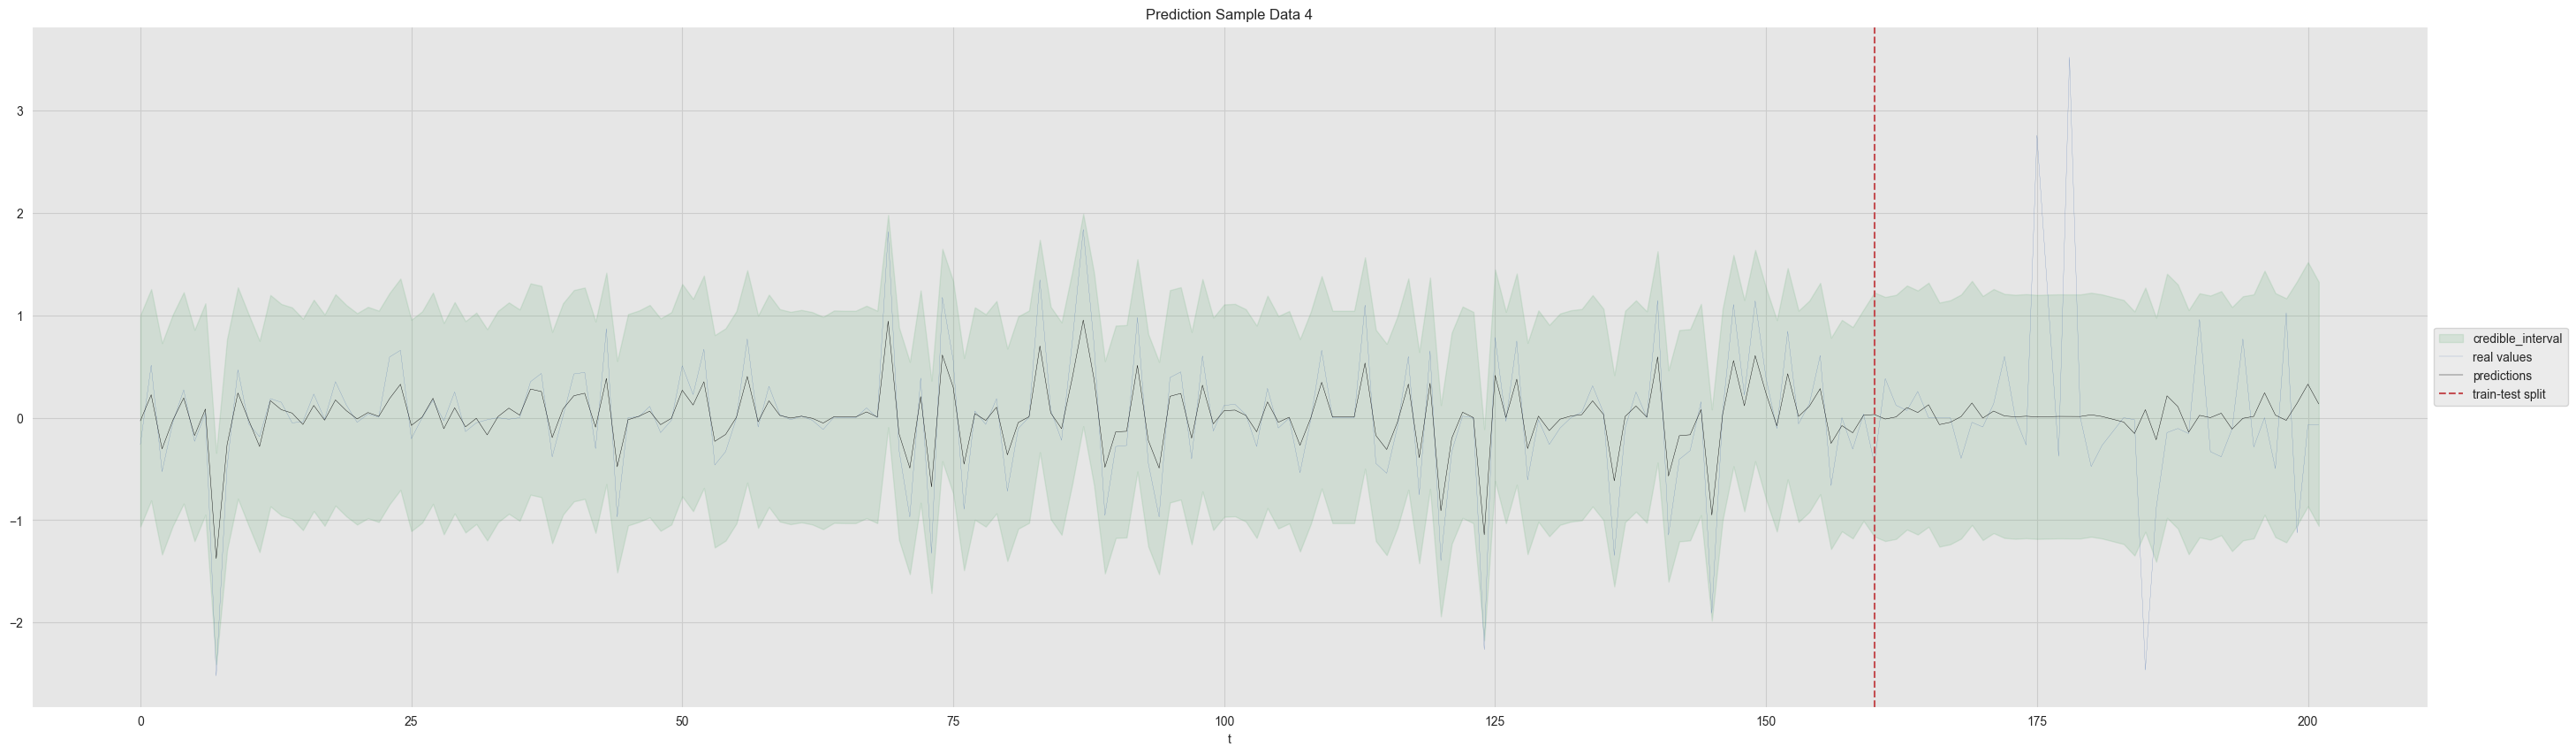

In [377]:
fig, ax = plt.subplots(figsize=(35,10))

ax.fill_between(
    x=df['t'],
    y1=df['y_pred_lwr'],
    y2=df['y_pred_upr'],
    color=sns_c[2],
    alpha=0.15,
    label='credible_interval'
)

sns.lineplot(x='t', y='delta', data=df, color=sns_c[0], label = 'real values', ax=ax, linewidth=0.15)
sns.lineplot(x='t', y='y_pred', data=df, color='black', label='predictions', ax=ax, linewidth=0.3)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample Data 4', xlabel='t', ylabel='');

# plt.savefig('prediction_sample.png', dpi=1200)

     Unnamed: 0                     symbolId  sequence  askPrice  \
0             0  QUOTE_COINBASE_SPOT_BTC_USD  12168757  19908.44   
1             1  QUOTE_COINBASE_SPOT_BTC_USD  12168805  19907.92   
2             2  QUOTE_COINBASE_SPOT_BTC_USD  12168716  19908.94   
3             3  QUOTE_COINBASE_SPOT_BTC_USD  12168852  19907.89   
4             4  QUOTE_COINBASE_SPOT_BTC_USD  12168941  19907.80   
..          ...                          ...       ...       ...   
197         197  QUOTE_COINBASE_SPOT_BTC_USD  12177760  19917.60   
198         198  QUOTE_COINBASE_SPOT_BTC_USD  12177844  19916.61   
199         199  QUOTE_COINBASE_SPOT_BTC_USD  12177891  19918.65   
200         200  QUOTE_COINBASE_SPOT_BTC_USD  12177995  19916.41   
201         201  QUOTE_COINBASE_SPOT_BTC_USD  12178020  19916.27   

                    partitionKey                 timeExchange   bidSize  \
0    QUOTE_COINBASE_SPOT_BTC_USD  2022-10-04T09:01:47.971965Z  0.000005   
1    QUOTE_COINBASE_SPOT_BTC_USD 

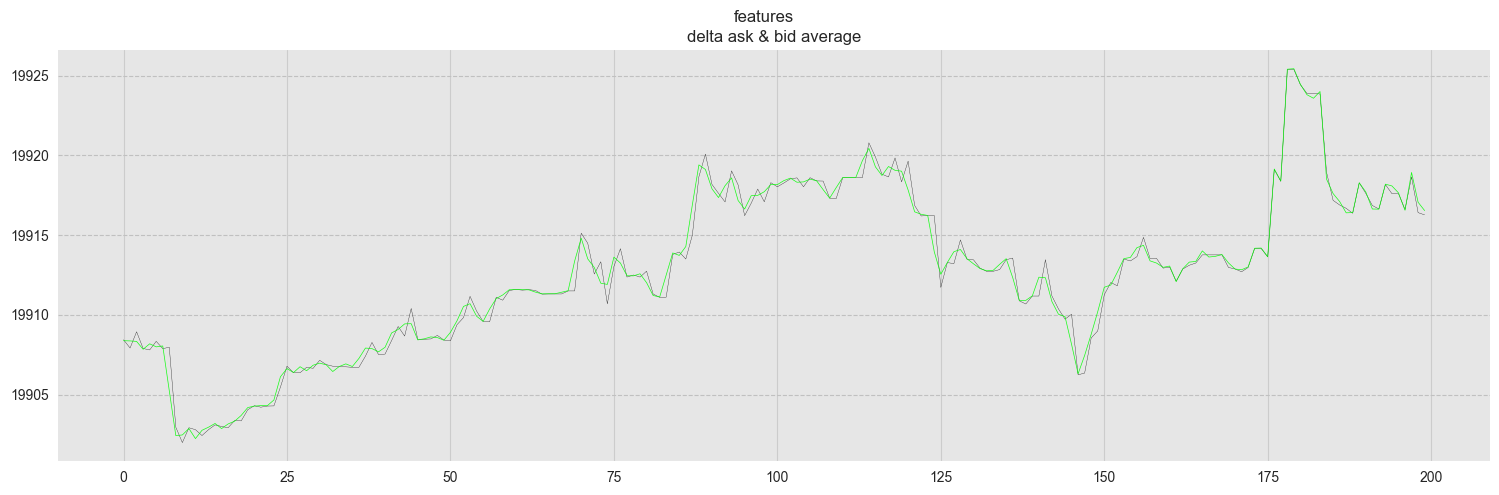

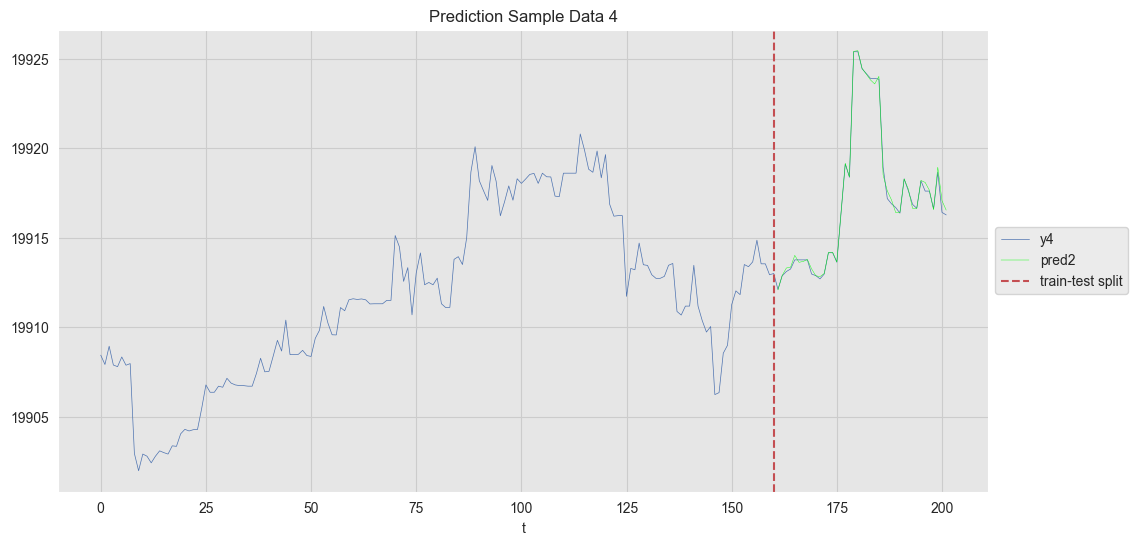

In [378]:
df['y_pred'] = df['y_pred'] / 10000 + 1
df['pred2'] = df['y_pred'] * df['askPrice']

print(df)

fig, (sp1) = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('features')

sp1.spines['top'].set_visible(False)
sp1.spines['right'].set_visible(False)
sp1.spines['left'].set_visible(False)
sp1.grid(axis='y', color='silver', linestyle='--', linewidth=0.8)

sp1.title.set_text('delta ask & bid average')
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.25)

sp1.plot(np.arange(0, df.shape[0]), df.askPrice, '-', color="black", alpha=0.9, linewidth=0.25)
sp1.plot(np.arange(0, df.shape[0]), df.pred2, '-', color="lime", alpha=0.9, linewidth=0.5)

plt.show()

fig, ax = plt.subplots()

# ax.fill_between(
#     x=df['t'],
#     y1=df['y_pred_lwr'],
#     y2=df['y_pred_upr'],
#     color=sns_c[2],
#     alpha=0.15,
#     label='credible_interval'
# )

sns.lineplot(x='t', y='askPrice', data=df, color=sns_c[0], label='y4', ax=ax, linewidth=0.5)
sns.lineplot(x='t', y='pred2', data=df[161:], color='lime', label='pred2', ax=ax, linewidth=0.3)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample Data 4', xlabel='t', ylabel='');



# plt.plot(np.arange(1247, 1558), df.askPrice[1247:], '-', color="black", alpha=0.9, linewidth=0.25)
# plt.plot(np.arange(1247, 1558), df.pred2[1247:], '-', color="lime", alpha=0.9, linewidth=0.15)

# plt.savefig('prediction_new.png', dpi=1200)

plt.show()


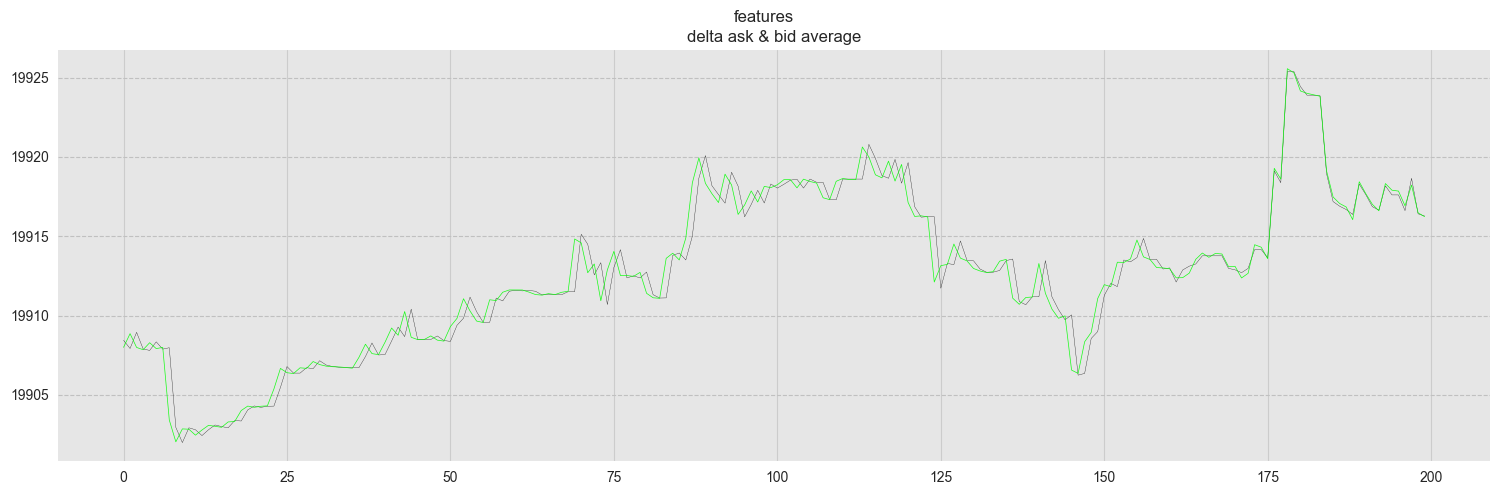

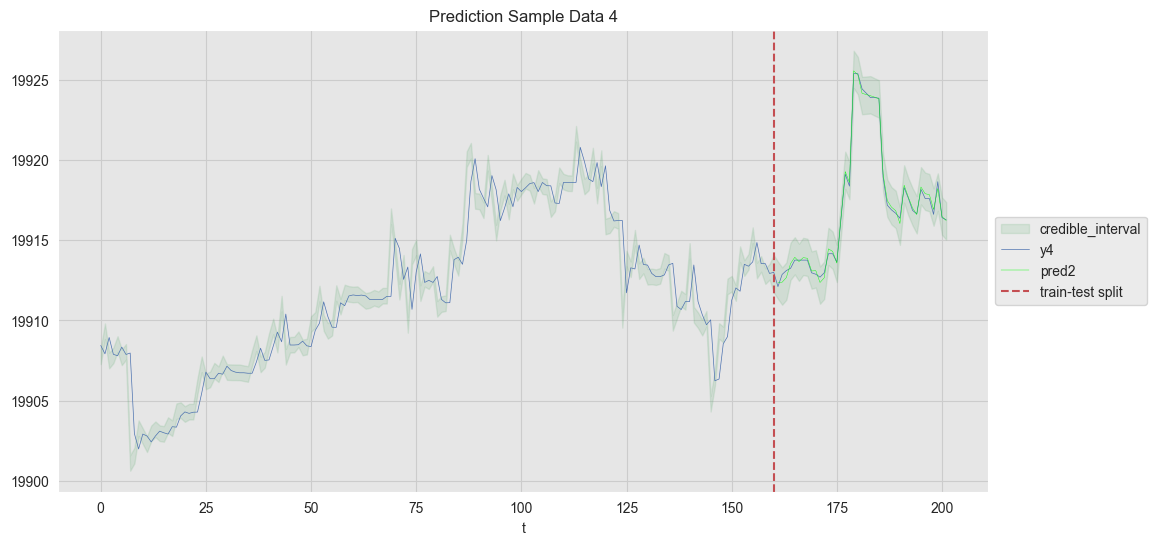

In [370]:
X = X[201:400]
X = df['t'].values.reshape(n, 1)
y = df['delta'].values.reshape(n, 1)

y_pred, y_std = gp4.predict(X, return_std=True)

fig, (sp1) = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle('features')

sp1.spines['top'].set_visible(False)
sp1.spines['right'].set_visible(False)
sp1.spines['left'].set_visible(False)
sp1.grid(axis='y', color='silver', linestyle='--', linewidth=0.8)

sp1.title.set_text('delta ask & bid average')
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=None, hspace=0.25)

sp1.plot(np.arange(0, df.shape[0]), df.askPrice, '-', color="black", alpha=0.9, linewidth=0.25)
sp1.plot(np.arange(0, df.shape[0]), df.pred2, '-', color="lime", alpha=0.9, linewidth=0.5)

plt.show()

fig, ax = plt.subplots()

ax.fill_between(
    x=df['t'],
    y1=df['pred2'] + df['y_pred_lwr'],
    y2=df['pred2'] + df['y_pred_upr'],
    color=sns_c[2],
    alpha=0.15,
    label='credible_interval'
)

sns.lineplot(x='t', y='askPrice', data=df, color=sns_c[0], label='y4', ax=ax, linewidth=0.5)
sns.lineplot(x='t', y='pred2', data=df[161:], color='lime', label='pred2', ax=ax, linewidth=0.3)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Prediction Sample Data 4', xlabel='t', ylabel='');



# plt.plot(np.arange(1247, 1558), df.askPrice[1247:], '-', color="black", alpha=0.9, linewidth=0.25)
# plt.plot(np.arange(1247, 1558), df.pred2[1247:], '-', color="lime", alpha=0.9, linewidth=0.15)

# plt.savefig('prediction_new.png', dpi=1200)

plt.show()
